In [98]:
from utils import *

In [99]:
#load the data
data = pd.read_csv(os.path.join('..', 'data', 'processed', 'points_aggregated_data.csv'), delimiter=';')

In [100]:
#define main mouse movement metric columns
columns = list(filter(lambda x: x not in (useless_columns + filter_columns + ['age', 'dpi', 'sens']), list(data.columns)))
data = data[columns + ['age', 'sens', 'dpi', 'sex', 'respondent_id']]
data.age = data.age.astype(float)

In [101]:
#prepare pipelines for ordinal and continous data
ordinal_pipe = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

continous_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson', standardize=True))
])

# define preprocessor
preprocessor = ColumnTransformer([
    ('continous', continous_pipe, [i for i in range(108)]),
    ('ordinal', ordinal_pipe, [108]),
], remainder='passthrough')

In [102]:
# define train test splits
data_splits = []

for index, tr_ids in enumerate(train_ids):
    train = data[data['respondent_id'].isin(tr_ids)]
    test = data[data['respondent_id'].isin(test_ids[index])]

    processed_train = pd.DataFrame(preprocessor.fit_transform(train[columns + ['sex']]), columns=columns + ['sex'])
    processed_test = pd.DataFrame(preprocessor.fit_transform(test[columns + ['sex']]), columns=columns + ['sex'])

    predictors_train = processed_train.iloc[:, [i for i in range(108)]]
    target_train = processed_train.iloc[:, 108]

    predictors_test = processed_test.iloc[:, [i for i in range(108)]]
    target_test = processed_test.iloc[:, 108]

    data_splits.append({
        'predictors_train': predictors_train,
        'predictors_test': predictors_test,
        'target_train': target_train,
        'target_test': target_test
    })

# Random Forest

In [14]:
# random forest with all predictors
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    model = RandomForestClassifier()
    model.fit(data_splits[i]['predictors_train'], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

Accuracy    0.5640
Precision   0.5645
Recall      0.5640
F1 score    0.5634
AUC score   0.5953
dtype: float64

In [ ]:
# parameters = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# model = RandomForestClassifier()

# best_fit = RandomizedSearchCV(
#     model, 
#     parameters, 
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1), 
#     n_iter = 100,
#     verbose=4, 
#     n_jobs=-1
# ).fit(data_splits[1]['predictors_train'], data_splits[1]['target_train'])
# print(best_fit)
# print(best_fit.best_params_)
# print(best_fit.best_score_)

In [46]:
# random forest with feature selection, hyperparameter tuning and cutoff
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    cols = my_select_features(data_splits[i]['predictors_train'], data_splits[i]['target_train'], RandomForestClassifier())
    cols = data_splits[i]['predictors_train'].columns[cols].values

    model = RandomForestClassifier(
        n_estimators=1200, 
        max_depth=30, 
        min_samples_leaf=2, 
        min_samples_split=5,
        bootstrap=False
    )

    best_auc = 0
    best_cutoff = 0

    model.fit(data_splits[i]['predictors_train'][cols], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'][cols])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'][cols])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    for cutoff in np.arange(0.01, 0.99, 0.001):
        test_predict_temp = list(map(lambda x: 1 if x > cutoff else 0, pred_proba))
        auc_score_temp = roc_auc_score(data_splits[i]['target_test'], test_predict_temp)
        if (auc_score_temp > best_auc):
            best_auc = auc_score_temp
            best_cutoff = cutoff

    report = classification_report(data_splits[i]['target_test'], [(0 if x <= best_cutoff else 1) for x in pred_proba], output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

Accuracy    0.6103
Precision   0.6257
Recall      0.6104
F1 score    0.5846
AUC score   0.5995
dtype: float64

# XGBoost

In [18]:
# xgboost with all predictors
filterwarnings('ignore')
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    model = XGBClassifier()
    model.fit(data_splits[i]['predictors_train'], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

Accuracy    0.5557
Precision   0.5559
Recall      0.5557
F1 score    0.5551
AUC score   0.5803
dtype: float64

In [14]:
# parameters = {
#     'eta' : [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25],
#     'gamma' : [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10],
#     'max_depth' : [2, 4, 6, 8, 10, 12],
#     'min_child_weight' : [0, 1, 2, 3, 5, 10],
#     'max_delta_step' : [0.5, 1, 2, 4, 8, 10, 12]
# }

# model = XGBClassifier()

# best_fit = RandomizedSearchCV(
#     model, 
#     parameters, 
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1), 
#     n_iter = 200,
#     verbose=4, 
#     n_jobs=-1
# ).fit(data_splits[1]['predictors_train'], data_splits[1]['target_train'])
# print(best_fit)
# print(best_fit.best_params_)
# print(best_fit.best_score_)

In [35]:
filterwarnings('ignore')
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    cols = my_select_features(data_splits[i]['predictors_train'], data_splits[i]['target_train'], XGBClassifier(logging_level='Silent'))
    cols = data_splits[i]['predictors_train'].columns[cols].values

    model = XGBClassifier(
        min_child_weight=10, 
        max_depth=12, 
        max_delta_step=1, 
        gamma=5, 
        eta=0.05
    )

    best_auc = 0
    best_cutoff = 0

    model.fit(data_splits[i]['predictors_train'][cols], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'][cols])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'][cols])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    for cutoff in np.arange(0.01, 0.99, 0.001):
        test_predict_temp = list(map(lambda x: 1 if x > cutoff else 0, pred_proba))
        auc_score_temp = roc_auc_score(data_splits[i]['target_test'], test_predict_temp)
        if (auc_score_temp > best_auc):
            best_auc = auc_score_temp
            best_cutoff = cutoff

    report = classification_report(data_splits[i]['target_test'], [(0 if x <= best_cutoff else 1) for x in pred_proba], output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

[10:29:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "logging_level" } are not used.

[10:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "logging_level" } are not used.

[10:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "logging_level" } are not used.

[10:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "logging_level" } are not used.

[10:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "logging_level" } 

Accuracy    0.5970
Precision   0.6050
Recall      0.5971
F1 score    0.5583
AUC score   0.5764
dtype: float64

# CatBoost

In [103]:
# catboost with all predictors
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    model = CatBoostClassifier(logging_level='Silent')
    model.fit(data_splits[i]['predictors_train'], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

Accuracy    0.5753
Precision   0.5755
Recall      0.5753
F1 score    0.5750
AUC score   0.5985
dtype: float64

In [ ]:
# parameters = {
#     'depth'           : [2, 4, 6, 8, 10],
#     'learning_rate'   : [0.01, 0.02, 0.04, 0.08, 0.1, 0.15, 0.2, 0.3],
#     'iterations'      : [200, 300, 500, 800, 1000],
#     'min_data_in_leaf': [1, 5, 20, 50, 100]
# }

# model = CatBoostClassifier(logging_level='Silent')

# best_fit = RandomizedSearchCV(
#     model, 
#     parameters, 
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1), 
#     n_iter=20,
#     verbose=4, 
#     n_jobs=-1
# ).fit(data_splits[1]['predictors_train'], data_splits[1]['target_train'])
# print(best_fit)
# print(best_fit.best_params_)
# print(best_fit.best_score_)

In [104]:
# custom selected catboost features (see 4_1)
selected_features = [
    'velocity_q95', 'velocity_x_median', 'velocity_y_mean_weighted',
    'acceleration_q5', 'acceleration_x_min', 'acceleration_x_q5',
    'acceleration_y_q5', 'acceleration_negative_mean',
    'velocity_angular_mean_weighted', 'velocity_angular_mean',
    'velocity_angular_std', 'curvature_min', 'curvature_q5',
    'curvature_mean', 'velocity_smooth_mean_weighted'
]

In [109]:
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])
probs = []

for i in range(10):

    model = CatBoostClassifier(
        logging_level='Silent',
        depth=8,
        iterations=1000,
        learning_rate=0.01,
        min_data_in_leaf=100,
        eval_metric="AUC",
    )

    best_auc = 0
    best_cutoff = 0

    model.fit(Pool(data_splits[i]['predictors_train'][selected_features], data_splits[i]['target_train']))
    pred = model.predict(data_splits[i]['predictors_test'][selected_features])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'][selected_features])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    for cutoff in np.arange(0.01, 0.99, 0.001):
        test_predict_temp = list(map(lambda x: 1 if x > cutoff else 0, pred_proba))
        auc_score_temp = roc_auc_score(data_splits[i]['target_test'], test_predict_temp)
        if (auc_score_temp > best_auc):
            best_auc = auc_score_temp
            best_cutoff = cutoff

    #report = classification_report(data_splits[i]['target_test'], [(0 if x <= best_cutoff else 1) for x in pred_proba], output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

    probs.append(pred_proba)

results.mean()

Accuracy    0.5953
Precision   0.5956
Recall      0.5953
F1 score    0.5948
AUC score   0.6205
dtype: float64

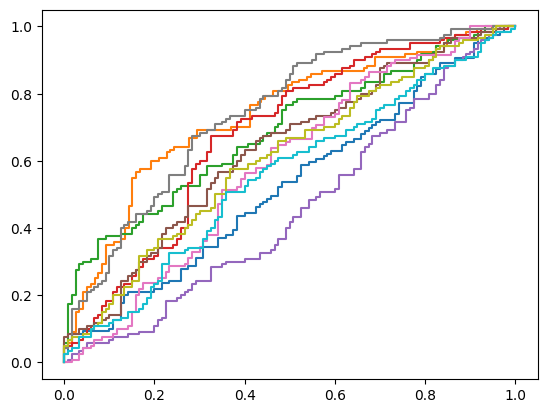

In [148]:
fprs = []
tprs = []

for i in range(10):
    fpr, tpr, _ = roc_curve(data_splits[i]['target_test'], probs[i], drop_intermediate=False)
    fprs.append(fpr)
    tprs.append(tpr)
    plt.plot(fpr, tpr)


In [150]:
mean_fpr = []
mean_tpr = []

for i in range(240):
    sum=[0,0]
    for j in range(10):
        sum[0]+=fprs[j][i]
        sum[1]+=tprs[j][i]
    mean_fpr.append(sum[0]/10)
    mean_tpr.append(sum[1]/10)

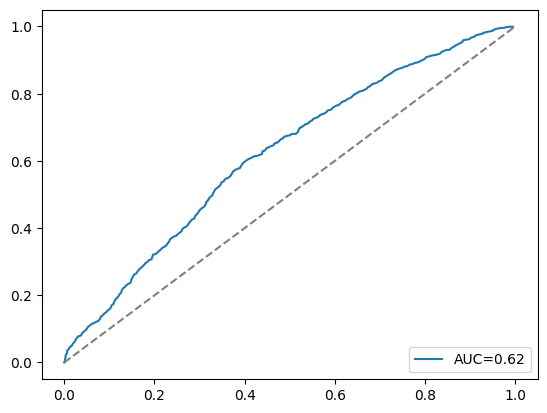

In [161]:
plt.plot(mean_fpr, mean_tpr, label='AUC='+str(results['AUC score'].mean().round(2)))
plt.plot(fpr,fpr,'--',color='grey')
plt.legend(loc=4)

# Logistic regression

In [33]:
filterwarnings('ignore')
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    model = LogisticRegression()
    model.fit(data_splits[i]['predictors_train'], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

Accuracy    0.5753
Precision   0.5754
Recall      0.5753
F1 score    0.5752
AUC score   0.6184
dtype: float64

In [41]:
# parameters = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100], 
#     'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear']
# }

# model = LogisticRegression()

# best_fit = RandomizedSearchCV(
#     model, 
#     parameters, 
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1), 
#     n_iter=100,
#     verbose=4, 
#     n_jobs=-1
# ).fit(data_splits[1]['predictors_train'], data_splits[1]['target_train'])
# print(best_fit)
# print(best_fit.best_params_)
# print(best_fit.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
                   estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   verbose=4)
{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}
0.6008426313342631


In [42]:
filterwarnings('ignore')
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    cols = my_select_features(data_splits[i]['predictors_train'], data_splits[i]['target_train'], LogisticRegression())
    cols = data_splits[i]['predictors_train'].columns[cols].values

    model = LogisticRegression(
        solver='newton-cg',
        penalty='l2',
        C=0.1
    )

    best_auc = 0
    best_cutoff = 0

    model.fit(data_splits[i]['predictors_train'][cols], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'][cols])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'][cols])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    for cutoff in np.arange(0.01, 0.99, 0.001):
        test_predict_temp = list(map(lambda x: 1 if x > cutoff else 0, pred_proba))
        auc_score_temp = roc_auc_score(data_splits[i]['target_test'], test_predict_temp)
        if (auc_score_temp > best_auc):
            best_auc = auc_score_temp
            best_cutoff = cutoff

    report = classification_report(data_splits[i]['target_test'], [(0 if x <= best_cutoff else 1) for x in pred_proba], output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

Accuracy    0.5999
Precision   0.6193
Recall      0.6000
F1 score    0.5754
AUC score   0.5850
dtype: float64

# LightGBM

In [36]:
filterwarnings('ignore')
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    model = LGBMClassifier(verbose=-1)
    model.fit(data_splits[i]['predictors_train'], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

  File "c:\Users\mkrajcovic\Desktop\mouse-dynamics-data-credibility\analysis\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Accuracy    0.5686
Precision   0.5690
Recall      0.5686
F1 score    0.5677
AUC score   0.5902
dtype: float64

In [24]:
# parameters = {
#     'num_leaves' : [2, 5, 10, 20, 50, 80, 100, 150, 200],
#     'max_depth' : [-1, 1, 3, 5, 7, 9, 12, 15],
#     'min_data_in_leaf' : [2, 3, 5, 10, 50, 100, 200, 300],
#     'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25],
#     'num_estimators' : [2, 5, 10, 50, 100, 200, 400, 800, 1200],
#     'max_bin' : [2, 5, 25, 50, 100, 200]
# }

# model = LGBMClassifier()

# best_fit = RandomizedSearchCV(
#     model, 
#     parameters, 
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1), 
#     n_iter = 100,
#     verbose=4, 
#     n_jobs=-1
# ).fit(data_splits[1]['predictors_train'], data_splits[1]['target_train'])
# print(best_fit)
# print(best_fit.best_params_)
# print(best_fit.best_score_)

In [37]:
filterwarnings('ignore')
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC score'])

for i in range(10):
    cols = my_select_features(data_splits[i]['predictors_train'], data_splits[i]['target_train'], LGBMClassifier(logging_level='Silent'))
    cols = data_splits[i]['predictors_train'].columns[cols].values

    model = LGBMClassifier(
        verbose=-1,
        num_leaves=10, 
        n_estimators=100,
        min_data_in_leaf=2,
        max_depth=-1,
        max_bin=200,
        learning_rate=0.01
    )

    best_auc = 0
    best_cutoff = 0

    model.fit(data_splits[i]['predictors_train'][cols], data_splits[i]['target_train'])
    pred = model.predict(data_splits[i]['predictors_test'][cols])
    pred_proba = model.predict_proba(data_splits[i]['predictors_test'][cols])[:,1]
    report = classification_report(data_splits[i]['target_test'], pred, output_dict=True)

    for cutoff in np.arange(0.01, 0.99, 0.001):
        test_predict_temp = list(map(lambda x: 1 if x > cutoff else 0, pred_proba))
        auc_score_temp = roc_auc_score(data_splits[i]['target_test'], test_predict_temp)
        if (auc_score_temp > best_auc):
            best_auc = auc_score_temp
            best_cutoff = cutoff

    report = classification_report(data_splits[i]['target_test'], [(0 if x <= best_cutoff else 1) for x in pred_proba], output_dict=True)

    results = pd.concat([results, pd.DataFrame(data={
        'Accuracy': [report['accuracy']],
        'Precision': [report['macro avg']['precision']],
        'Recall': [report['macro avg']['recall']],
        'F1 score': [report['macro avg']['f1-score']],
        'AUC score': [roc_auc_score(data_splits[i]['target_test'], pred_proba)]
    })])

results.mean()

[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Info] Number of positive: 360, number of negative: 359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22110
[LightGBM] [Info] Number of data points in the train set: 719, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500695 -> initscore=0.002782
[LightGBM] [Info] Start training from score 0.002782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

Accuracy    0.5965
Precision   0.6191
Recall      0.5964
F1 score    0.5708
AUC score   0.5796
dtype: float64